# Download dataset with Pytorch



## Load the data

In [1]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from PIL import Image


# Define transformation for each image
transform  = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x).flatten()) #Stretch image into row [32,32,3] -> [3072]
])

# Download a CIFAR10 dataset
dataset = datasets.CIFAR10("content",
                           train=True,
                           transform = transform,
                           download=True)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting content/cifar-10-python.tar.gz to content


## Split dataset & define dataloaders

torch.Size([256, 3072]) torch.Size([256])


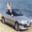

1

In [3]:
train_ds, val_ds, _= random_split(dataset, [20000,1000 ,29000])
# Hint: Perform debug on smaller subset

batch_size = 256

train_loader = DataLoader(train_ds, batch_size = batch_size)
val_loader = DataLoader(val_ds, batch_size = batch_size)

# Display one image
for images, class_nums in train_loader:
  print (images.shape,class_nums.shape) # class_nums are tensor!
  display(Image.fromarray(images[0].reshape((32,32,3)).numpy()),class_nums[0].item()) 
  break 


# Implement LinearClassifier class for CIFAR10

In [40]:
import random

random.seed(6512)

class LinearClassifier:
    def __init__(self, labels):
        self.labels = labels
        self.classes_num = len(labels)
        self.W = np.random.randn(3073, self.classes_num) * 0.0001 
        self.batch_size = 200


    def train(self, x_batch, y_batch, learning_rate = 1e-8):
        """
            Arguments:
            x  (numpy.array): collection of objects (batch)
            y  (numpy.array): collection of integer 
            representing a class number for objects from x

        """
        loss = 0.0
        train_len = x_batch.shape[0]
        numbers = list(range(train_len))
        random.shuffle(numbers)

        for i in range(0, train_len, self.batch_size):
            current_slice = numbers[i : i + self.batch_size]
            X_batch, Y_batch = x_batch[current_slice], y_batch[current_slice]
            X_batch = np.hstack([X_batch, np.ones((X_batch.shape[0], 1))])

            loss_val, dW_val = self.loss(X_batch, Y_batch)
            loss += loss_val
            self.W -= learning_rate * dW_val

        return loss/x_batch.shape[0]

    def loss(self,x, y): # x and y are batches
        """
            Arguments:
            x  (numpy.array): collection of objects (batch)
            y  (numpy.array): collection of integer 
            representing a class number for objects from x

        """

        loss = 0.0
        dW = np.zeros(self.W.shape)

        # Calculate Multiclass SVM or Cross-entropy loss over a batch 
        size = x.shape[0]
        for i in range(size):
            counter = 0
            scores = x[i].dot(self.W)
            for j in range(self.classes_num):
                if j == y[i]:
                    continue
                
                gain = scores[j] - scores[y[i]] + 1
                if gain <= 0:
                    continue
                
                counter += 1
                loss += gain
                dW[:, j] += x[i]
            
            dW[:, y[i]] -= counter * x[i]

        # Calculate gradients (dL/dW) and store it in dW
        loss /= size
        dW /= size

        return loss, dW
        
    def predict(self,x):
        x = self.add_ones(x)
        scores = x.dot(self.W) # (256, 3073) * (3073, 10)
        return np.argmax(scores, axis = 1)

    # https://stackoverflow.com/questions/36247067/how-to-add-ones-to-matrix
    def add_ones(self,x):
        return np.append(x, np.ones([x.shape[0], 1], dtype=np.int32), axis=1)

# Train model

## Function for accuracy checking

Don't change this code

In [41]:
from sklearn.metrics import accuracy_score

def validate(model,dataloader):
  y_predicted = np.array([])
  y_gtrue = np.array([])
  for images, class_nums in dataloader:
    index = model.predict(images.numpy())
    y_predicted = np.append(y_predicted,index) 
    y_gtrue = np.append(y_gtrue,class_nums.numpy()) 
  return accuracy_score(y_gtrue, y_predicted)  

## Train loop
Let's train our model

In [42]:

model = LinearClassifier(dataset.classes)
best_accuracy = 0
for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model.train(images.numpy(), class_nums.numpy())
    accuracy = validate(model,val_loader)
  if best_accuracy < accuracy:
     best_accuracy = accuracy
  print(f"Epoch {epoch} Loss: {loss}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy}")

Epoch 0 Loss: 0.18451194803479076, Accuracy:0.277
Epoch 1 Loss: 0.1679409316648983, Accuracy:0.313
Epoch 2 Loss: 0.15324056224821503, Accuracy:0.336
Epoch 3 Loss: 0.15319983225206804, Accuracy:0.337
Epoch 4 Loss: 0.14597804064310702, Accuracy:0.354
Epoch 5 Loss: 0.14763627918899314, Accuracy:0.344
Epoch 6 Loss: 0.143472039912722, Accuracy:0.366
Epoch 7 Loss: 0.14458218866406597, Accuracy:0.362
Epoch 8 Loss: 0.14198769531108393, Accuracy:0.373
Epoch 9 Loss: 0.14815466524266055, Accuracy:0.37
Epoch 10 Loss: 0.13973845158232262, Accuracy:0.374
Epoch 11 Loss: 0.13091155133540694, Accuracy:0.373
Epoch 12 Loss: 0.13309781341672372, Accuracy:0.381
Epoch 13 Loss: 0.13727422243910203, Accuracy:0.381
Epoch 14 Loss: 0.14071881609608333, Accuracy:0.371
Epoch 15 Loss: 0.13254962213728377, Accuracy:0.382
Epoch 16 Loss: 0.13842503989058458, Accuracy:0.382
Epoch 17 Loss: 0.13258601959504915, Accuracy:0.371
Epoch 18 Loss: 0.13125980078209712, Accuracy:0.384
Epoch 19 Loss: 0.13523209106724196, Accuracy:

# Check model on test dataset

You must get accuracy above 0.35


In [44]:
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = transform, # Transforms stay the same
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = batch_size)

accuracy = validate(model,test_loader)
print(f"Accuracy on test:{accuracy}")


Files already downloaded and verified
Accuracy on test:0.3539


# Place for brief conclusion
Feel free to describe troubles here.


...



# Ideas for extra work

- Implenment CrossEntropyLoss function
- Implement bias trick
- Add regularization to SVM loss
- Find best learning rate and regularization strength using Cross-Validation
- Normalize data


 